In [1]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential, Model
from tensorflow import keras
import os
import matplotlib.pyplot as plt
import string
from keras.applications.resnet50 import ResNet50
from pickle import dump
from pickle import load
from IPython.display import Image
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
import numpy as np
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.all_utils import plot_model
from keras.utils.np_utils import to_categorical
from keras.layers.merge import add, concatenate
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
# Defining the Dataset path
image_dataset_path = r'E:\Content\Data Science\Training Content\@Projects\Datasets\Flickr8k_Dataset\Flicker8k_Dataset'
caption_dataset_path = r'E:\Content\Data Science\Training Content\@Projects\Datasets\Flickr8k_text\Flickr8k.token.txt'

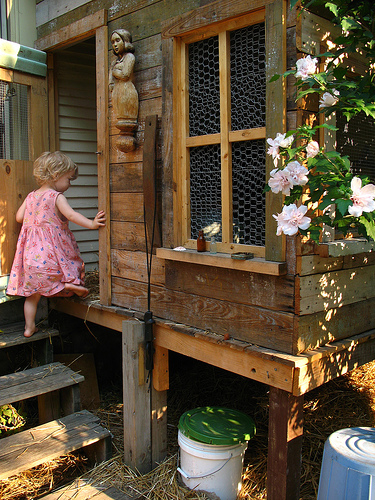

In [6]:
# Visulaizing the Image Data
Image(image_dataset_path+r'\1000268201_693b08cb0e.jpg')

In [15]:
def load_caption_file(path):
    captions_dict = {}
    for caption in open(path):
        tokens = caption.split()
        caption_id, caption_text = tokens[0].split('.')[0], tokens[1:]
        caption_text = ' '.join(caption_text)
        if caption_id not in captions_dict:
            captions_dict[caption_id] = caption_text
    return captions_dict

captions_dict = load_caption_file(caption_dataset_path)

In [16]:
captions_dict

{'1000268201_693b08cb0e': 'A child in a pink dress is climbing up a set of stairs in an entry way .',
 '1001773457_577c3a7d70': 'A black dog and a spotted dog are fighting',
 '1002674143_1b742ab4b8': 'A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
 '1003163366_44323f5815': 'A man lays on a bench while his dog sits by him .',
 '1007129816_e794419615': 'A man in an orange hat starring at something .',
 '1007320043_627395c3d8': 'A child playing on a rope net .',
 '1009434119_febe49276a': 'A black and white dog is running in a grassy garden surrounded by a white fence .',
 '1012212859_01547e3f17': 'A dog shakes its head near the shore , a red ball next to it .',
 '1015118661_980735411b': 'A boy smiles in front of a stony wall in a city .',
 '1015584366_dfcec3c85a': 'A black dog leaps over a log .',
 '101654506_8eb26cfb60': 'A brown and white dog is running through the snow .',
 '101669240_b2d3e7f17b': 'A man in a hat is displaying pictures ne

In [6]:
new_captions_dict = {}
table = str.maketrans('', '', string.punctuation)
for caption_id, caption_text in captions_dict.items():
    caption_text = caption_text.split()
    caption_text = [token.lower() for token in caption_text]
    caption_text = [token.translate(table) for token in caption_text]
    caption_text = [token for token in caption_text if len(token)>1]
    new_captions_dict[caption_id] = 'beginseq ' + ' '.join(caption_text) + ' endseq'

In [14]:
new_captions_dict

{'1000268201_693b08cb0e': 'startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 '1001773457_577c3a7d70': 'startseq black dog and spotted dog are fighting endseq',
 '1002674143_1b742ab4b8': 'startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
 '1003163366_44323f5815': 'startseq man lays on bench while his dog sits by him endseq',
 '1007129816_e794419615': 'startseq man in an orange hat starring at something endseq',
 '1007320043_627395c3d8': 'startseq child playing on rope net endseq',
 '1009434119_febe49276a': 'startseq black and white dog is running in grassy garden surrounded by white fence endseq',
 '1012212859_01547e3f17': 'startseq dog shakes its head near the shore red ball next to it endseq',
 '1015118661_980735411b': 'startseq boy smiles in front of stony wall in city endseq',
 '1015584366_dfcec3c85a': 'startseq black dog leaps over log endseq',
 '101654506_8eb26cfb60': 'startseq brown and white d

In [8]:
del captions_dict

In [9]:
print('"' + list(new_captions_dict.keys())[0] + '"' + ' : ' + new_captions_dict[list(new_captions_dict.keys())[0]])

"1000268201_693b08cb0e" : startseq child in pink dress is climbing up set of stairs in an entry way endseq


In [10]:
caption_images_list = []
image_index = list(new_captions_dict.keys())
caption_images_list = [ image.split('.')[0] for image in os.listdir(image_dataset_path) if image.split('.')[0] in image_index ]

In [11]:
len(caption_images_list)

8091

In [12]:
train_validate_images = caption_images_list[0:8081]  
test_images = caption_images_list[8081:8091]

In [15]:
def extract_features(directory, image_keys):
    model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')
    print(model.summary())
    features = dict()
    for name in image_keys:
        filename = directory + '/' + name + '.jpg'
        image = load_img(filename, target_size=(224, 224))
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)
        feature = model.predict(image, verbose=0)
        image_id = name.split('.')[0]
        features[image_id] = feature
    return features

In [16]:
train_validate_features = extract_features(image_dataset_path, train_validate_images)

94773248/94765736 [==============================] - 10s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_________________________

In [ ]:
# Printing the features extracted from a sample image.
print("{} : {}".format(list(train_validate_features.keys())[0], train_validate_features1[list(train_validate_features1.keys())[0]] ))

In [ ]:
len(train_validate_features)

In [ ]:
# Converting the features into pickle format for later uses.
dump(train_validate_features, open('img_capt_valid_feats.pkl', 'wb'))

In [ ]:
train_validate_image_caption = {}
for image, caption in new_captions_dict.items():
    # check whether the image is available in both train_validate_images list and train_validate_features dictionary
    if image in train_validate_images and image in list(train_validate_features1.keys()):
         train_validate_image_caption.update({image : caption})
len(train_validate_image_caption)

In [ ]:
Image(image_dataset_path+'\\'+list(train_validate_image_caption.keys())[2]+'.jpg')

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(train_validate_image_caption.values()))
vocab_len = len(tokenizer.word_index) + 1
max_len = max(len(train_validate_image_caption[image].split()) for image in train_validate_image_caption)

print("vocab_len ", vocab_len)
print("max_len ", max_len)

def prepare_data(image_keys):
    # x1 will store the image feature, x2 will store one sequence and y will store the next sequence
    x1, x2, y = [], [], []
    for image in image_keys:
        caption = train_validate_image_caption[image]
        caption = caption.split()
        seq = tokenizer.texts_to_sequences([caption])[0]
        length = len(seq)
        for i in range(1, length):
            x2_seq, y_seq = seq[:i] , seq[i]  
            x2_seq = pad_sequences([x2_seq], maxlen = max_len)[0]
            y_seq = to_categorical([y_seq], num_classes = vocab_len)[0]
            x1.append( train_validate_features1[image][0] )
            x2.append(x2_seq)
            y.append(y_seq)
    return np.array(x1), np.array(x2), np.array(y)

In [ ]:
train_x1, train_x2, train_y = prepare_data( train_validate_images[0:7081] )
validate_x1, validate_x2, validate_y = prepare_data( train_validate_images[7081:8081] )

In [ ]:
embedding_size = 128
image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(Dropout(0.5))
image_model.add(RepeatVector(max_len))

image_model.summary()

In [ ]:
language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_len, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256,return_sequences=True))
language_model.add(Dropout(0.5))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

In [ ]:
# Final Model
conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, dropout=0.5, recurrent_dropout=0.5,return_sequences=True)(conca)
x = LSTM(512, dropout=0.5, recurrent_dropout=0.5,return_sequences=False)(x)
x = Dense(vocab_len)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
model.summary()

In [ ]:
filepath = 'image_caption_model.h5'
callbacks = [ ModelCheckpoint(filepath= filepath, verbose = 2,save_best_only=True, monitor='val_loss', mode='min') ]

In [ ]:
print("shape of train_x1 ", train_x1.shape)
print("shape of train_x2 ", train_x2.shape)
print("shape of train_y ", train_y.shape)
print()
print("shape of validate_x1 ", validate_x1.shape)
print("shape of validate_x2 ", validate_x2.shape)
print("shape of validate_y ", validate_y.shape)

In [ ]:
# Training the model
BATCH_SIZE = 512
EPOCHS = 100
history = model.fit([train_x1, train_x2],  
                    train_y,              
                    verbose = 1,            
                    epochs = EPOCHS,
                    batch_size = BATCH_SIZE,
                    callbacks = callbacks, 
                    validation_data=([validate_x1, validate_x2], validate_y)) 

In [ ]:
# plot the training artifacts
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()

In [ ]:
# extract features from each photo in the directory
def extract_feat(filename):    
    model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')
    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    return feature

# map an integer to a word
def word_for_id(integer, tokenizr):
    for word, index in tokenizr.word_index.items():
        if index == integer:
            return word
    return None 

In [ ]:
def generate_desc(model, tokenizer, photo, max_length):    
    in_text = 'beginseq'    
    for i in range(max_length):        
        sequence = tokenizer.texts_to_sequences([in_text])[0]        
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

In [ ]:
# generate a description for an image
model = load_model('image_caption_model.h5')
tokenizr = Tokenizer()
tokenizr.fit_on_texts([caption for image, caption in new_captions_dict.items() if image in train_validate_images])
max_length = max_len
photo = extract_feat('{}/3561433412_3985208d53.jpg'.format(image_directory))  

in_text = 'beginseq'

for i in range(max_length):
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    sequence = pad_sequences([sequence], maxlen=max_length)
    yhat = model.predict([photo,sequence], verbose=0)
    yhat = np.argmax(yhat)
    word = word_for_id(yhat, tokenizer)
    if word is None:
        break
    in_text += ' ' + word
    if word == 'endseq':
        break
in_text = in_text.replace('beginseq','') 
in_text = in_text.replace('endseq','') 
print("Predicted caption -> ", in_text)
print()
print('*********************************************************************')
Image('{}/3561433412_3985208d53.jpg'.format(image_directory))